In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory = directory_project
# update_plate_info(directory)

In [ ]:
directory = "/projects/0/einf914/agg/"
# update_plate_info(directory)

In [22]:
directory_project, directory

('/projects/0/einf914/data/', '/scratch-shared/amftrack/data/')

In [3]:
update_plate_info(directory, local=True)
all_folders = get_current_folders(directory, local=True)
len(all_folders)

analysed:   0%|          | 0/2332 [00:00<?, ?it/s]

2177

In [5]:
# folders = all_folders.loc[all_folders['Temp'].isin(['30to25'])]
# print(len(folders))
folders = all_folders
folders = folders.loc[folders["/Analysis/skeleton_pruned_compressed.mat"] == True]
print(len(folders))
folders = folders.loc[folders["/Analysis/skeleton_realigned_compressed.mat"] == True]
print(len(folders))
folders = folders.loc[folders["Plate"] == "737"]
print(len(folders))

0
0
0


***Chose plate number and directory of interest where the folders with images are***

In [13]:
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]

In [8]:
plates = [
    "139_20201214",
    "40_20201214",
    "799_20211001",
    
]

In [4]:
plates = [
    "139_20201214",
    # "40_20201214",
    # "799_20211001",
    
]

In [5]:
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.loc[
    folders["/Analysis/skeleton_pruned_compressed.mat"] == True
].sort_values("datetime")
folders

total_path Plate PrincePos  \
1389  /projects/0/einf914/data/20201217_0835_Plate09   139         9   

          root strain      medium split Pbait CrossDate Temperature  ...  \
1389  'Carrot'   'A5'  '001P100N'   'Y'   '-'  20201214         NaN  ...   

     /Analysis/transform_corrupt.mat  \
1389                           False   

     /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
1389                                        True                        True   

     /Analysis/nx_graph_pruned_width.p /Analysis/nx_graph_pruned_labeled.p  \
1389                              True                                True   

                    date                 folder Temp     unique_id  \
1389  17.12.2020, 08:35:  20201217_0835_Plate09   25  139_20201214   

                datetime  
1389 2020-12-17 08:35:00  

[1 rows x 25 columns]

***Chose timestep to begin with and folder to end with***

***Stitching***

In [8]:
num_parallel = 50
time = "40:00"
run_parallel_stitch(directory, folders, num_parallel, time, cpus=128, node="fat")

FileNotFoundError: No such file: '/projects/0/einf914/data/20220429_1331_Plate22/Img/Img_r03_c05.tif'

***Skeletonization***
- Only 128 skeletonization processes can be run in parallel on one fat node

In [12]:
num_parallel = 100
time = "3:00:00"
low = 40
high = 80
extend = 30
args = [low, high, extend, directory]
run_parallel(
    "extract_skel.py",
    args,
    folders,
    num_parallel,
    time,
    "skeletonization",
    cpus=32,
    node="fat",
)

sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
sbatch: By default shared jobs get 7680 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 0.25 node, based on the number of CPUs, GPUs and the amount memory that you've requested.


Submitted batch job 2386218


In [14]:
num_parallel = 100
time = "6:00:00"
hyph_width = 30
perc_low = 93
perc_high = 99.5
args = [hyph_width, perc_low, perc_high, directory]
run_parallel(
    "extract_skel_2.py",
    
    args,
    folders,
    num_parallel,
    time,
    "skeletonization",
    cpus=128,
    node="fat",
)

Submitted batch job 2356763


***Compress raw image***

In [6]:
num_parallel = 100
time = "4:00"
args = [directory]
run_parallel(
    "compress_image.py",
    args,
    folders,
    num_parallel,
    time,
    "compress",
    cpus=128,
    node="fat",
)

Submitted batch job 1116476
Submitted batch job 1116477
Submitted batch job 1116478


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.


***Check Skeletonization***
- The first cell loads the skeleton and the compressed raw image
- The second cell shows the overlap of the skeleton and the raw image

In [8]:
# select = all_folders.loc[(all_folders['folder'].isin([ '20210929_0308_Plate21',
#  '20210929_0912_Plate21']))]
select = folders
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 10
start = 0

# start = choice(range(len(folder_list)))
finish = start + 2
for folder in folder_list[start:finish]:
    # print(folder)
    path_snap = directory + folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    #     im = imageio.imread(path_snap+'/StitchedImage.tif')
    #     im = cv2.resize(im,(skel.shape[1],skel.shape[0]))
    #     M = np.float32([
    # 	[1, 0, 0],
    # 	[0, 1, -117]])
    #     im = cv2.warpAffine(im,M,(im.shape[1], im.shape[0]))
    ims.append(im)

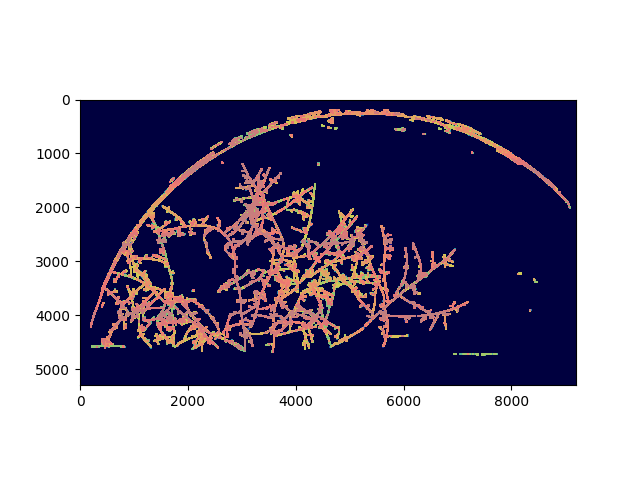

In [9]:
plt.close("all")
start = 0
finish = start + 1
for i in range(start, finish):
    plot_t_tp1([], [], None, None, skels[i], skels[i])

In [11]:
skel = read_mat(path_snap + "/Analysis/skeleton.mat")["skeleton"]
skeleton = scipy.sparse.dok_matrix(skel)
nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))


path_save = path_snap + "/Analysis/nx_graph_pruned_labeled.p"
print(path_save)
pickle.dump((nx_graph, pos), open(path_save, "wb"))

- Chose start and finish to display the overlap of the skeleton and the raw image : no more than 10 at a time or jupyter will crash.
- For display purpose, everything is compressed so connectivity may be lost
- colors are just a feature of compression

***Check specific image***
- If something wrong is noticed in one of the skeletons one can chose to look closer at one of the images and the skeletonization process
- chose ***i*** equal to the timestep where something wrong has been noticed 

In [8]:
# chose i equal to the timestep where something wrong has been noticed
i = 1
folder_list = list(folders["folder"])
folder_list.sort()
directory_name = folder_list[i]
path_snap = directory + directory_name
path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)
ims = []
for name in tileconfig[0]:
    imname = "/Img/" + name.split("/")[-1]
    ims.append(imageio.imread(directory + directory_name + imname))

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


- Chose a x,y position where you want to see how the skeletonization process went (x is the scale on the left on the images and y is the bottom scale)
- You can chose to display different part of the filter par commenting/uncommenting

59
Raw image
Raw image with background removed
frangised image
final transformed image
threhsolded image
threhsolded image
extended tips
final_skel


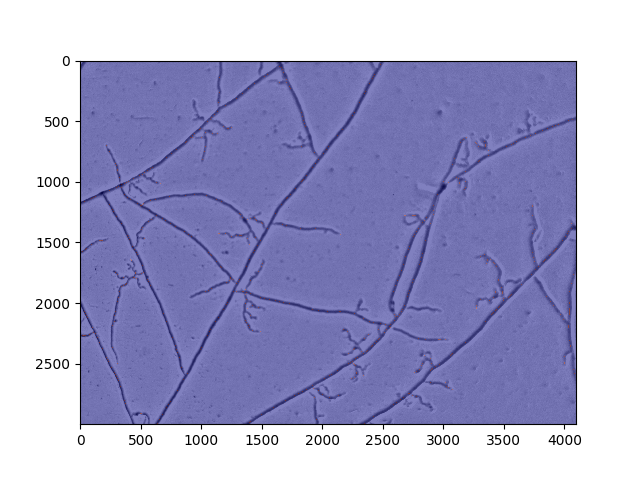

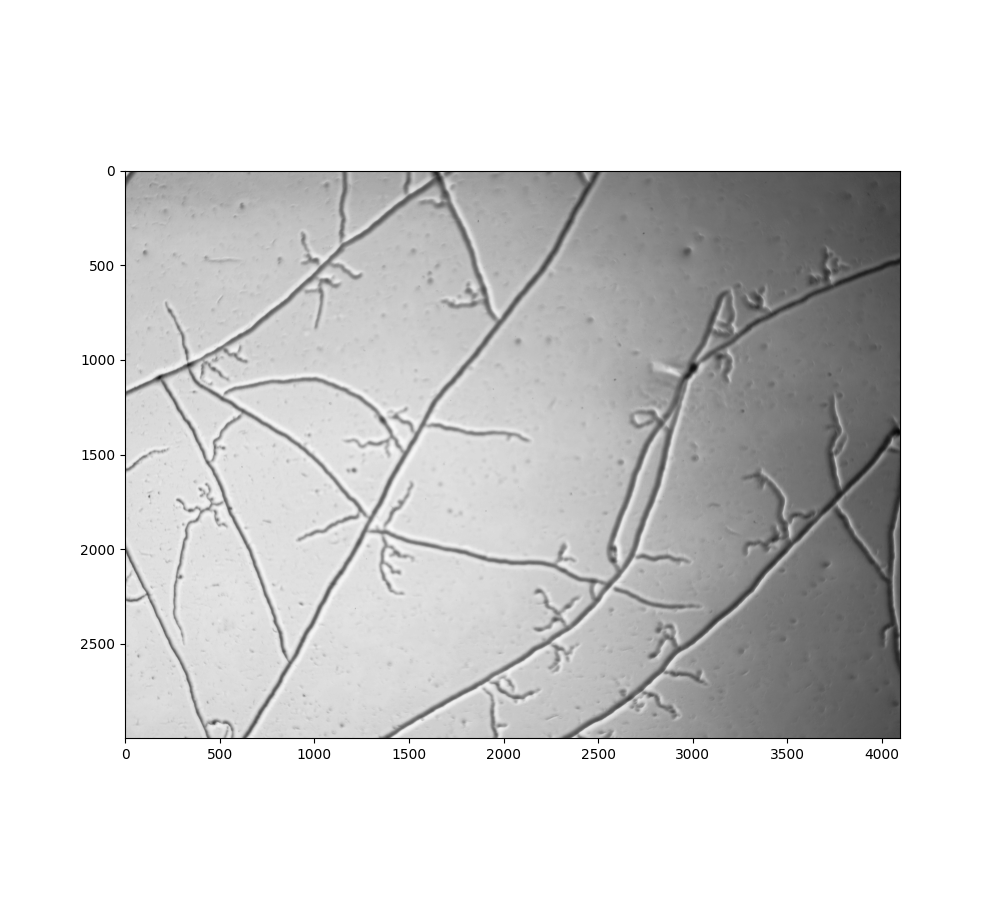

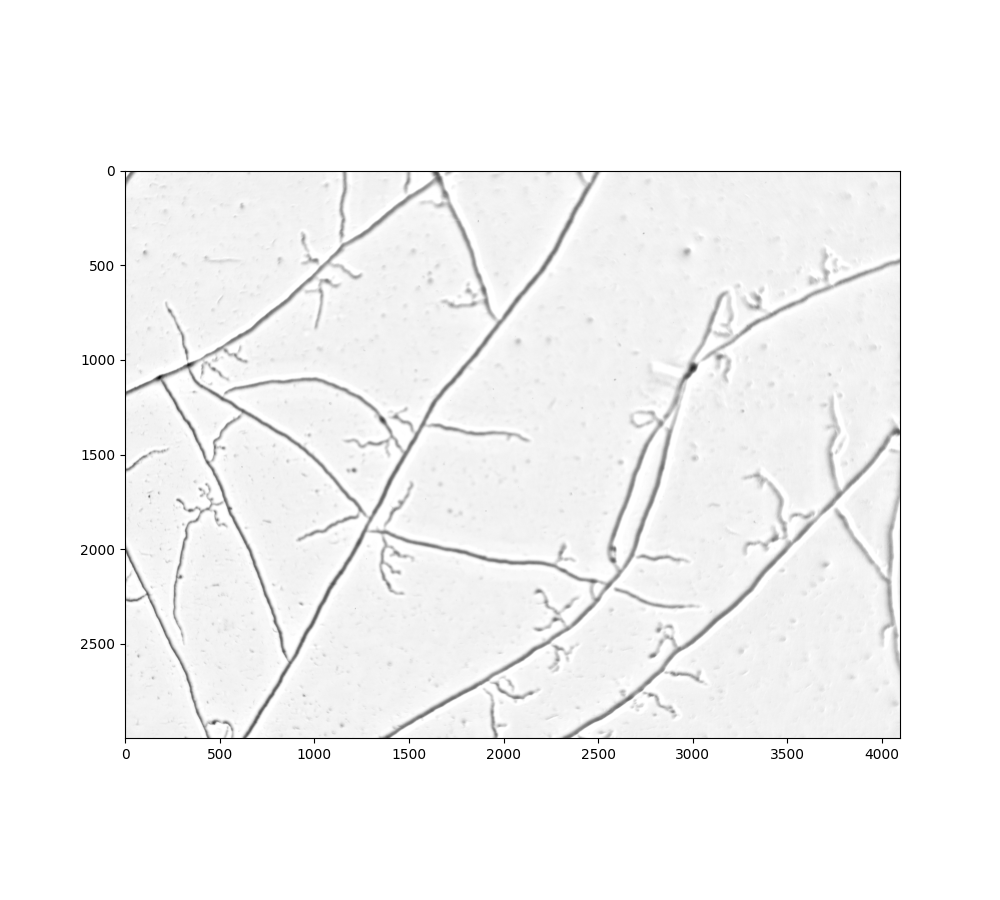

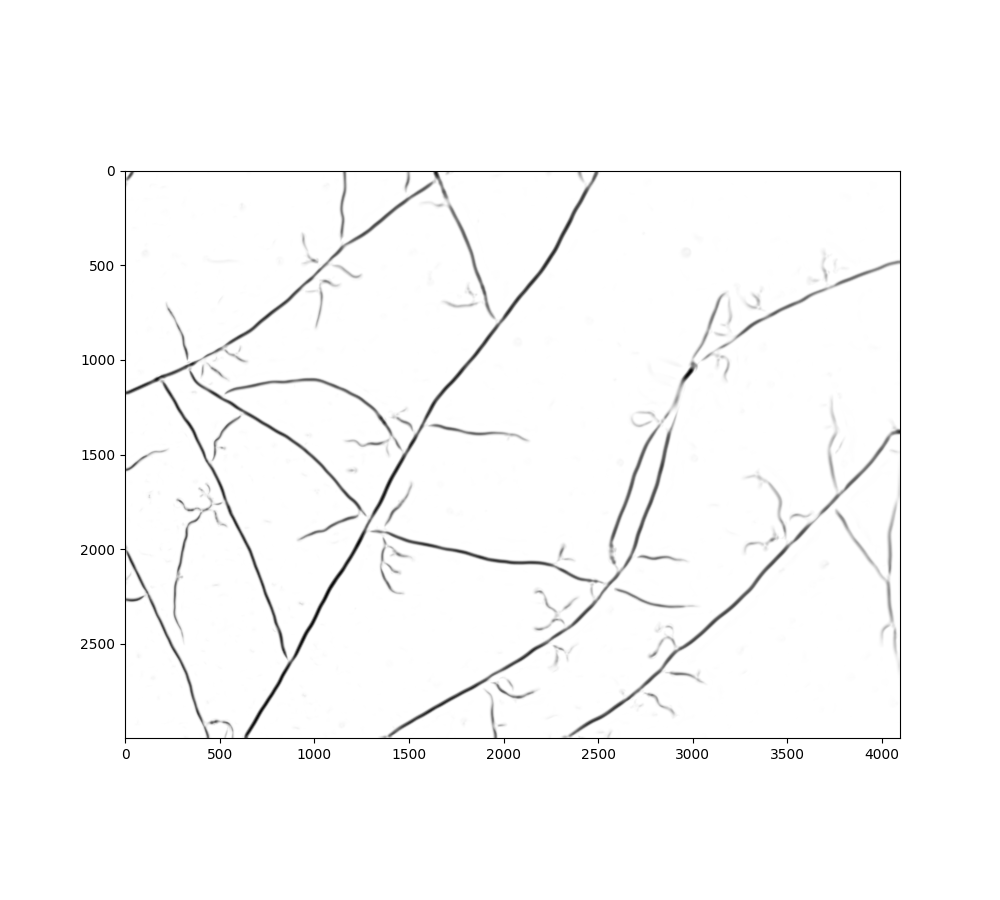

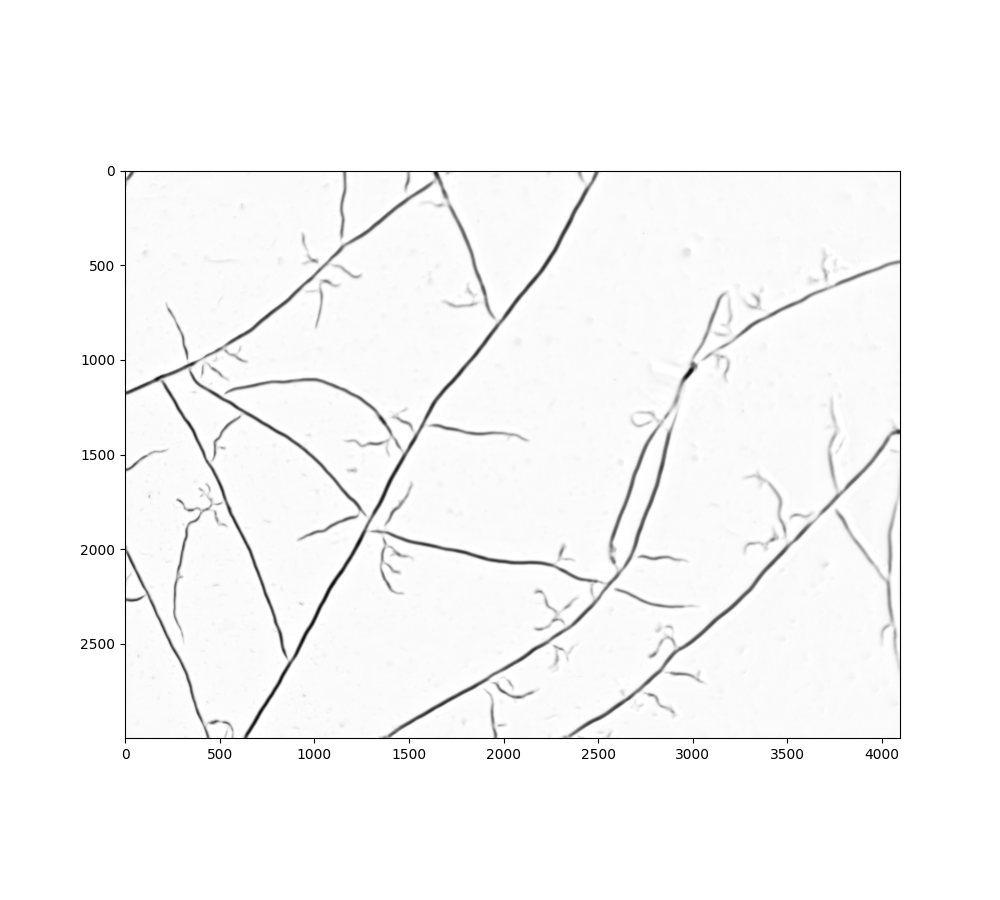

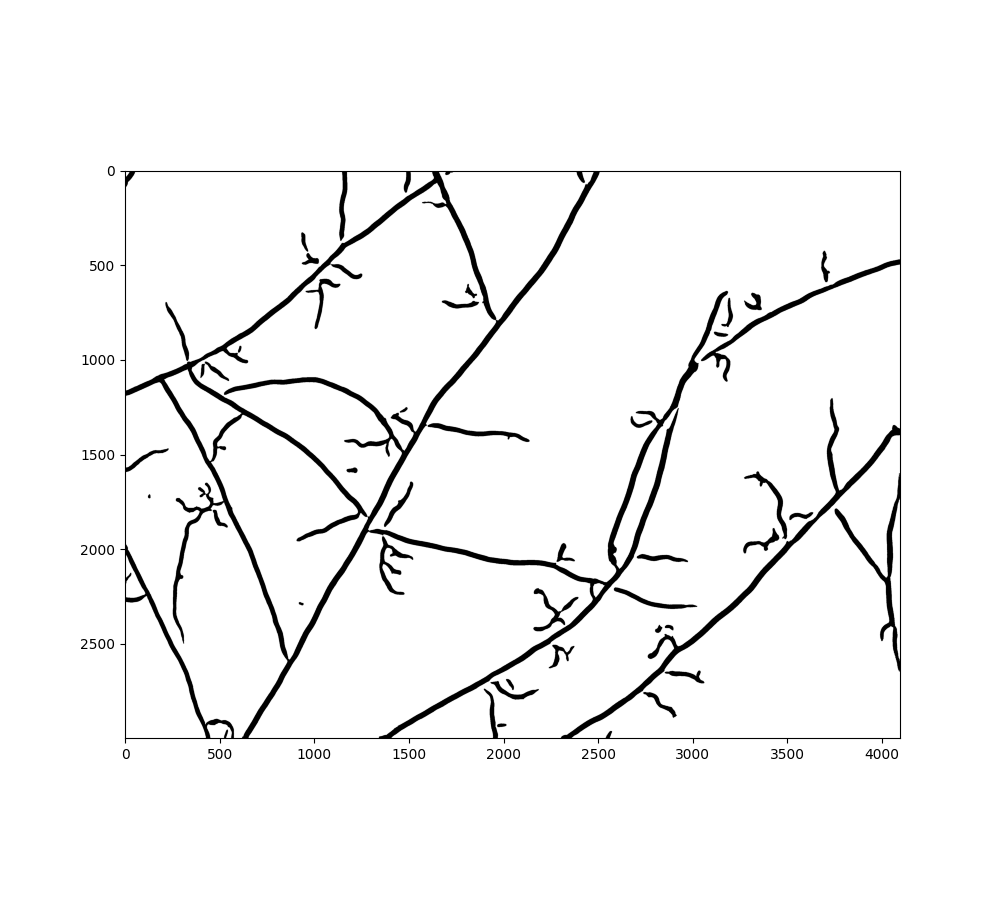

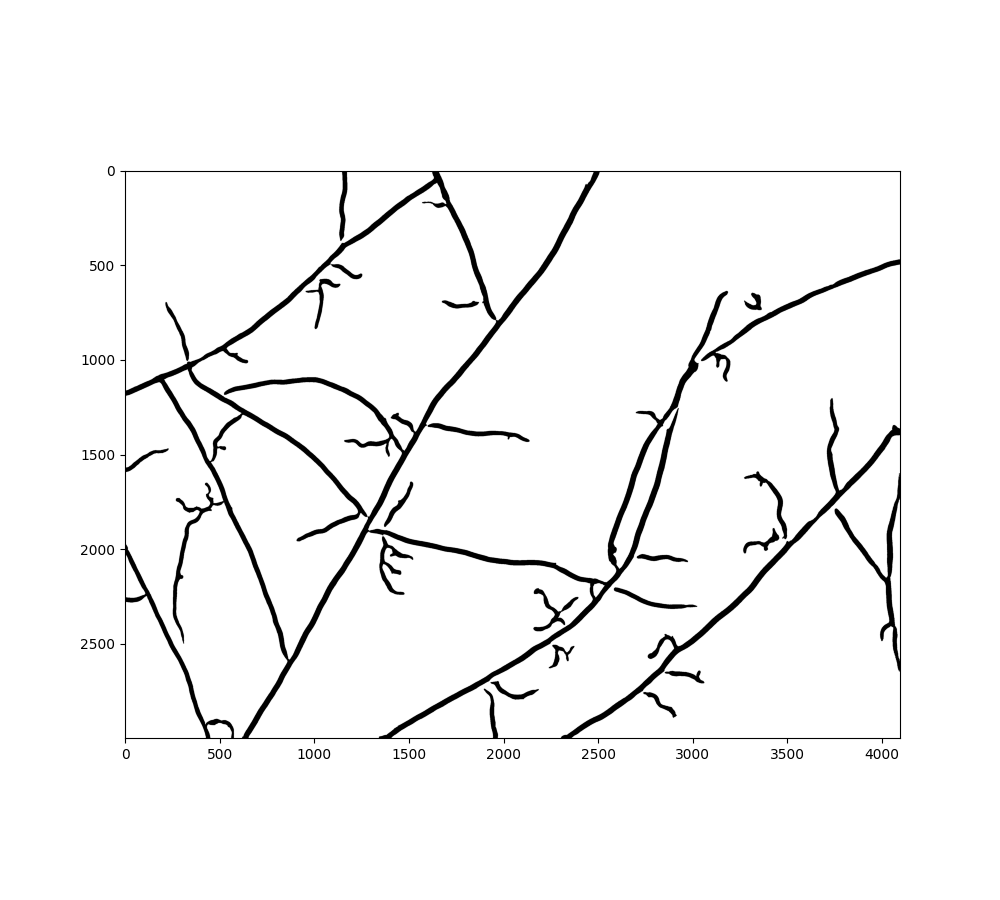

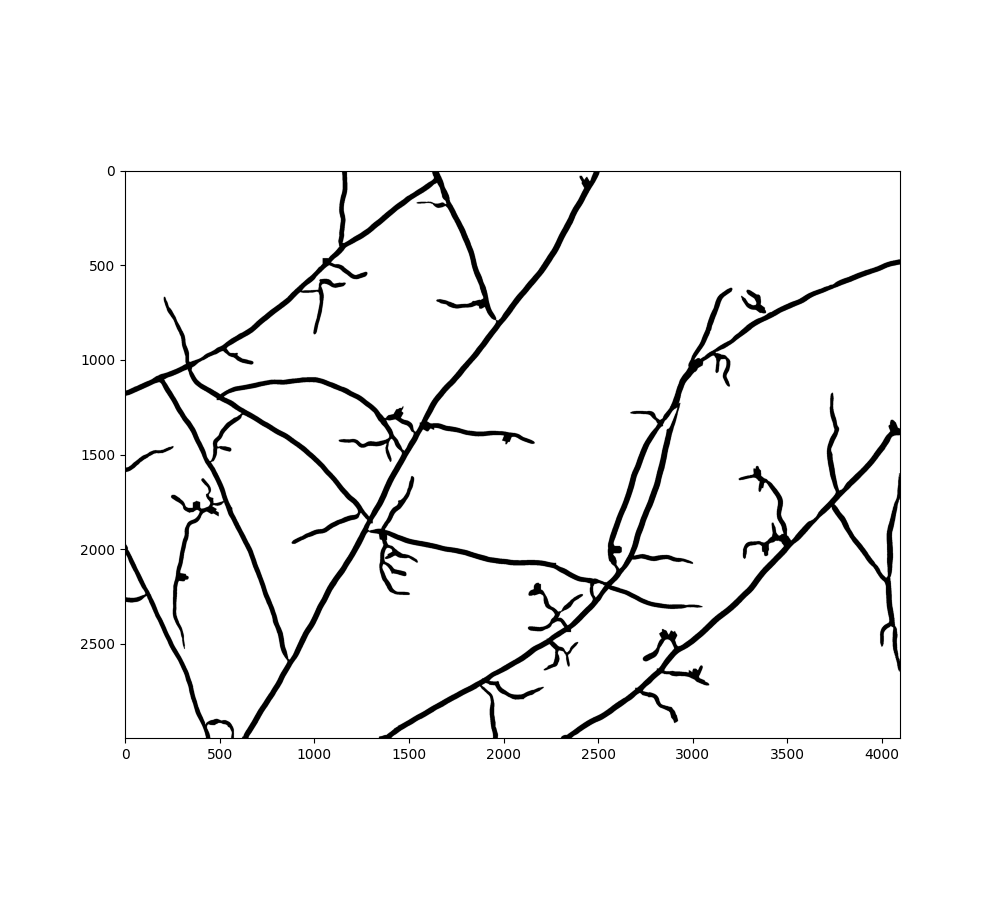

In [9]:
from amftrack.pipeline.functions.image_processing.extract_graph import orient

plt.close("all")

# chose a spot where to look closer at
linex = 3000
liney = 5400
low = 40
high = 80
extend = 30
dist = extend
shape = (3000, 4096)
linex *= 5
liney *= 5
for index, im in enumerate(ims):
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    if (
        boundaries[1] <= linex < boundaries[1] + shape[0]
        and boundaries[0] <= liney < boundaries[0] + shape[1]
    ):
        print(index)
        im_cropped = im
        #         im_blurred =cv2.GaussianBlur(im_cropped, (201, 201),50)
        im_blurred = cv2.blur(im_cropped, (200, 200))
        im_back_rem = (
            (im_cropped)
            / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred)
            * 120
        )
        im_back_rem[im_back_rem >= 130] = 130
        # im_back_rem = im_cropped*1.0
        # # im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
        frangised = frangi(im_back_rem, sigmas=range(1, 20, 4)) * 255
        # # frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
        hessian = hessian_matrix_det(im_back_rem, sigma=20)
        blur_hessian = cv2.blur(abs(hessian), (20, 20))
        #     transformed = (frangised+cv2.normalize(blur_hessian, None, 0, 255, cv2.NORM_MINMAX)-im_back_rem+120)*(im_blurred>=35)
        #     transformed = (frangised+cv2.normalize(abs(hessian), None, 0, 255, cv2.NORM_MINMAX)-im_back_rem+120)*(im_blurred>=35)
        transformed = (frangised - im_back_rem + 120) * (im_blurred >= 35)

        lowt = (transformed > low).astype(int)
        hight = (transformed > high).astype(int)
        hyst = filters.apply_hysteresis_threshold(transformed, low, high)
        kernel = np.ones((3, 3), np.uint8)
        dilation = cv2.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
        for i in range(3):
            dilation = cv2.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
            dilation = cv2.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilated = dilation > 0

        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
            dilated.astype(np.uint8), connectivity=8
        )
        # connectedComponentswithStats yields every seperated component with information on each of them, such as size
        # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        # minimum size of particles we want to keep (number of pixels)
        # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
        min_size = 4000

        # your answer image
        img2 = np.zeros((dilated.shape))
        # for every component in the image, you keep it only if it's above min_size
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                img2[output == i + 1] = 1
        skeletonized = cv2.ximgproc.thinning(np.array(255 * img2, dtype=np.uint8))
        nx_g = generate_nx_graph(
            from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized))
        )
        g, pos = nx_g
        tips = [node for node in g.nodes if g.degree(node) == 1]
        dilated_bis = np.copy(img2)
        for tip in tips:
            branch = np.array(
                orient(g.get_edge_data(*list(g.edges(tip))[0])["pixel_list"], pos[tip])
            )
            orientation = branch[0] - branch[min(branch.shape[0] - 1, 20)]
            orientation = orientation / (np.linalg.norm(orientation))
            window = 20
            x, y = pos[tip][0], pos[tip][1]
            if (
                x - window >= 0
                and x + window < dilated.shape[0]
                and y - window >= 0
                and y + window < dilated.shape[1]
            ):
                shape_tip = dilated[x - window : x + window, y - window : y + window]
                #             dist = 20
                for i in range(dist):
                    pixel = (pos[tip] + orientation * i).astype(int)
                    xp, yp = pixel[0], pixel[1]
                    if (
                        xp - window >= 0
                        and xp + window < dilated.shape[0]
                        and yp - window >= 0
                        and yp + window < dilated.shape[1]
                    ):
                        dilated_bis[
                            xp - window : xp + window, yp - window : yp + window
                        ] += shape_tip
        dilation = cv2.dilate(dilated_bis.astype(np.uint8) * 255, kernel, iterations=1)
        for i in range(3):
            dilation = cv2.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
            dilation = cv2.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilation = cv2.erode(
            dilation.astype(np.uint8) * 255, kernel, iterations=2
        )  # recent addition for agg, careful
        skeletonized = cv2.ximgproc.thinning(
            np.array(255 * (dilation > 0), dtype=np.uint8)
        )
        print("Raw image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(-im, cmap="Greys")
        print("Raw image with background removed")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(-im_back_rem, cmap="Greys")
        print("frangised image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(frangised, cmap="Greys")
        print("final transformed image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(transformed, cmap="Greys")
        print("threhsolded image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(dilated > 0, cmap="Greys")
        print("threhsolded image")
        fig = plt.figure(figsize=(10, 9))

        ax = fig.add_subplot(111)
        ax.imshow(img2 > 0, cmap="Greys")
        print("extended tips")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(dilated_bis > 0, cmap="Greys")
        print("final_skel")
        #         fig=plt.figure(figsize=(10,9))
        #         ax = fig.add_subplot(111)
        #         ax.imshow(cv2.normalize(abs(hessian), None, 0, 255, cv2.NORM_MINMAX)-255*dilated)
        plot_t_tp1([], [], None, None, skeletonized, im_back_rem)

108
Raw image
Raw image with background removed
bowled image
final transformed image
threhsolded image
threhsolded image


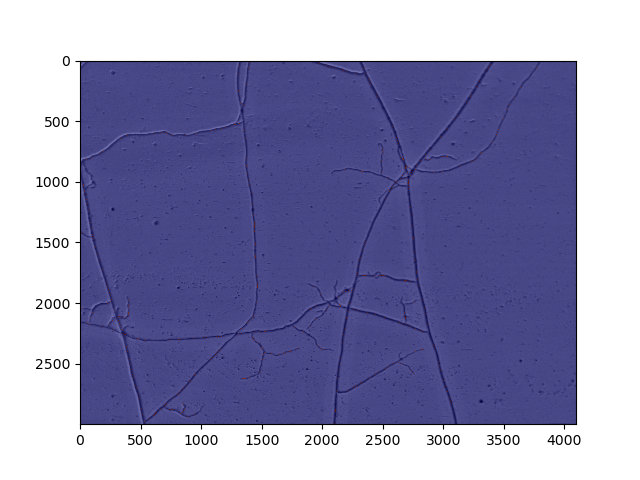

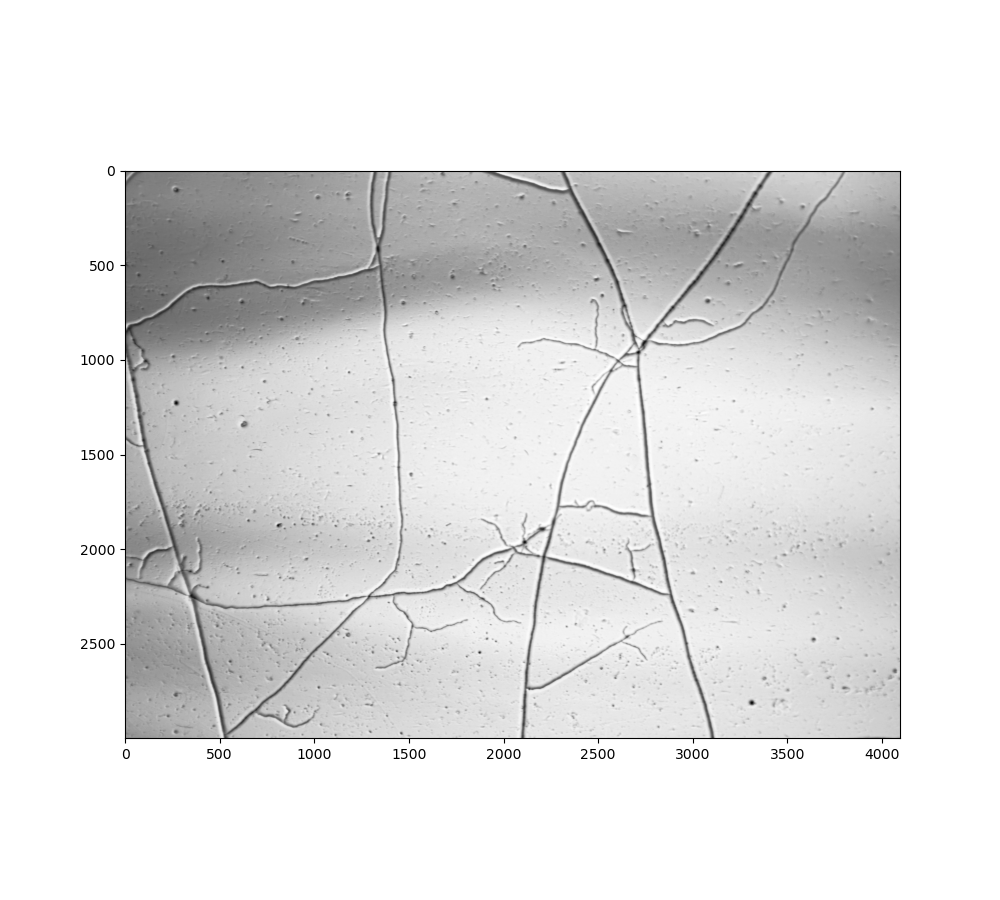

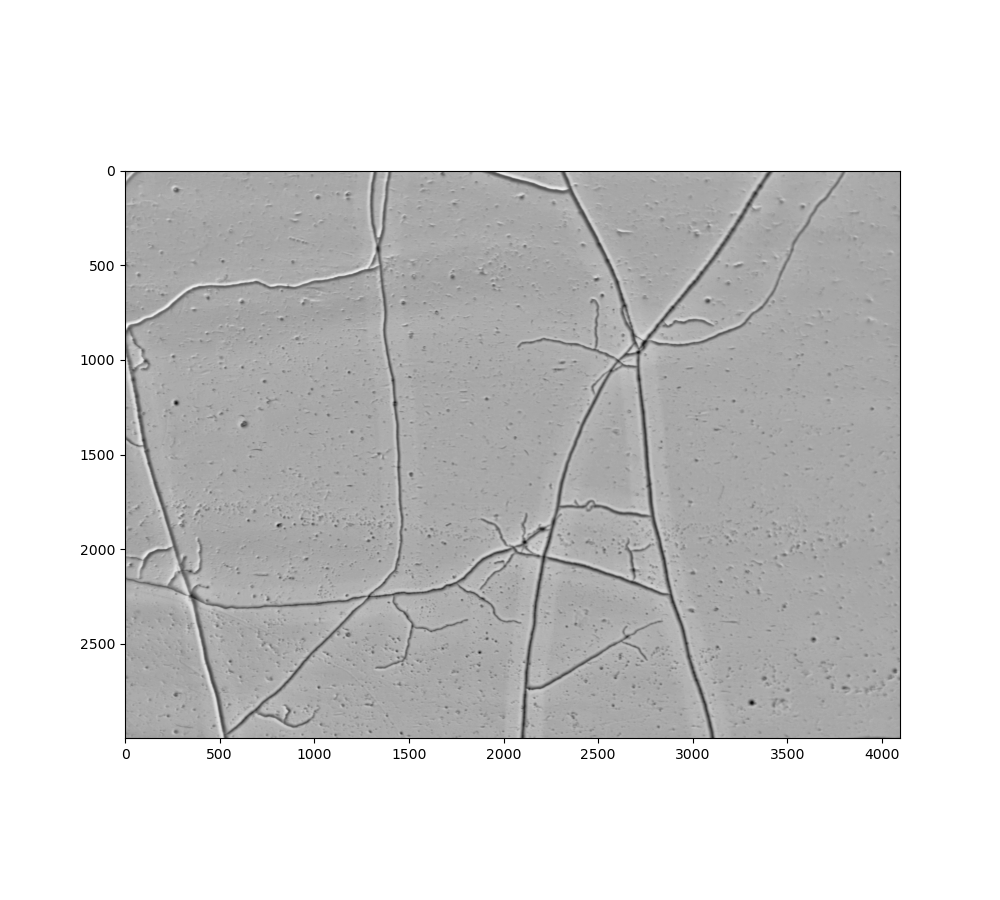

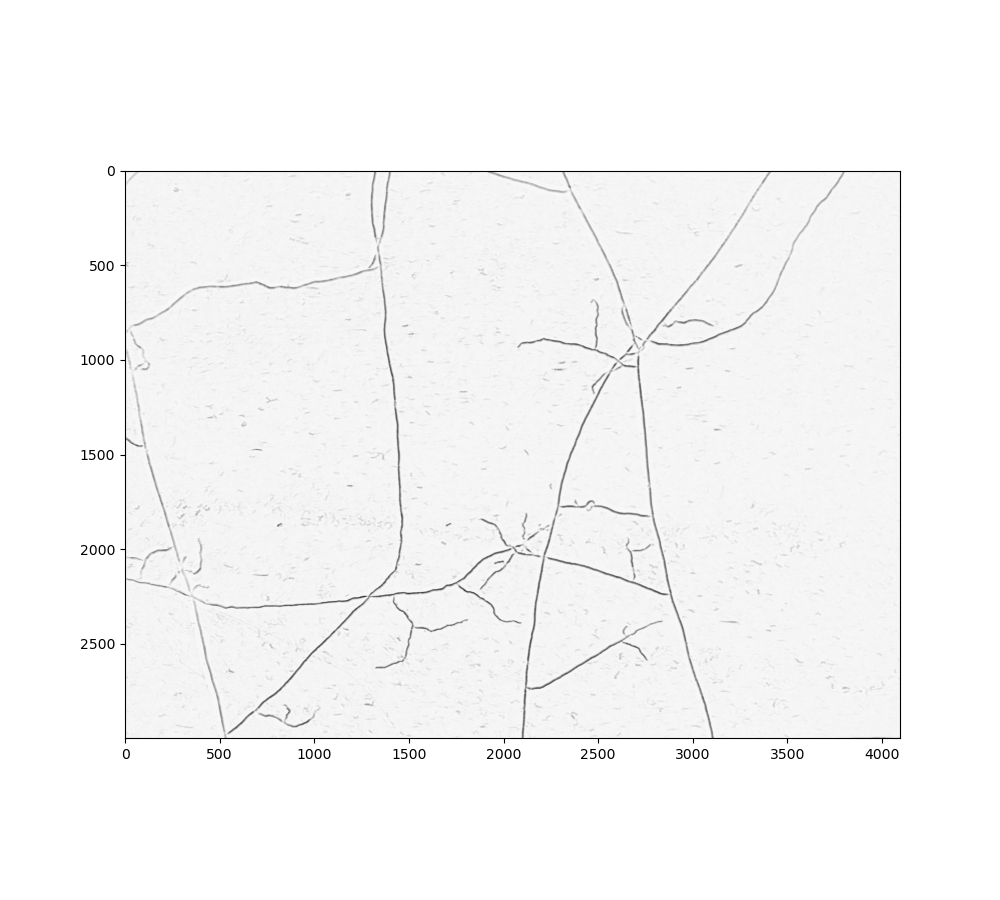

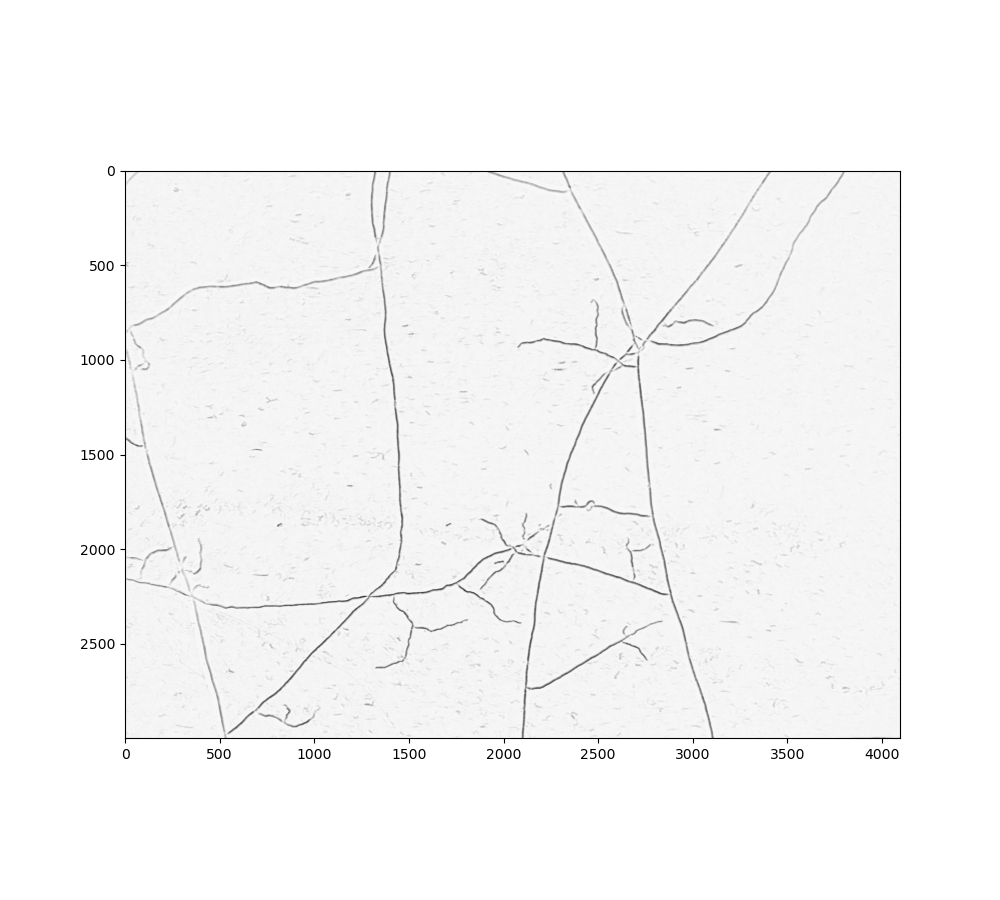

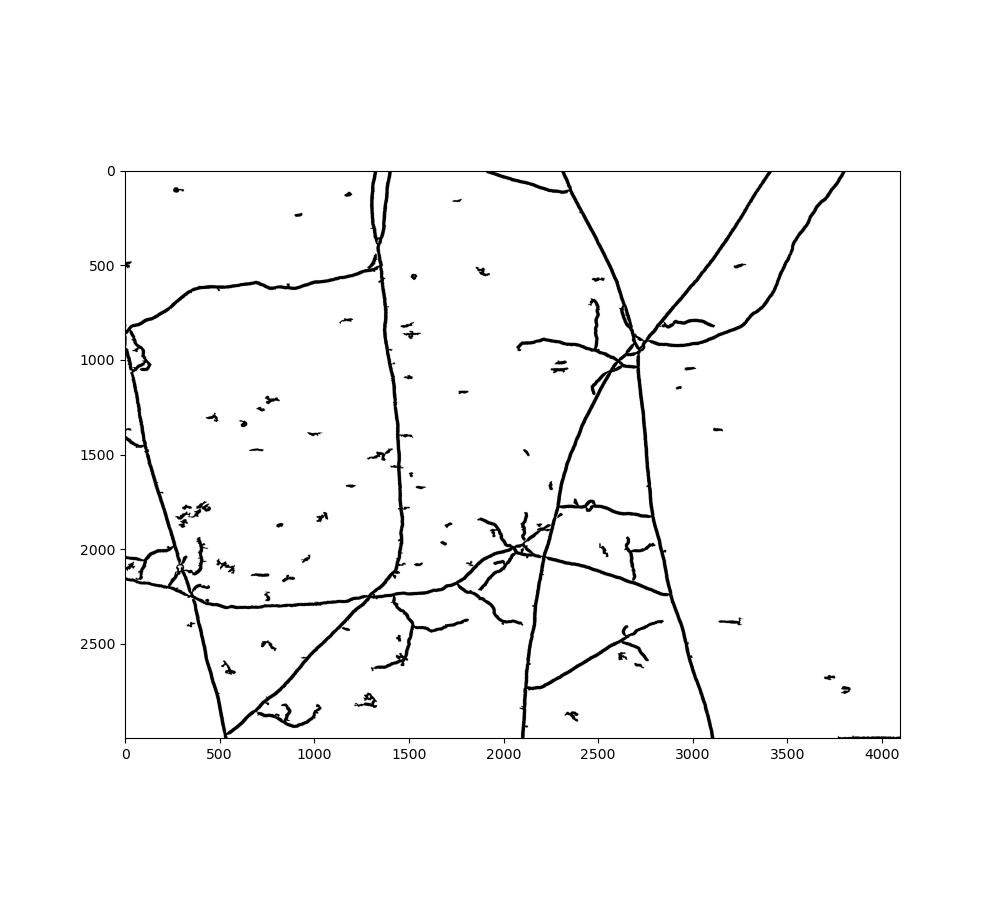

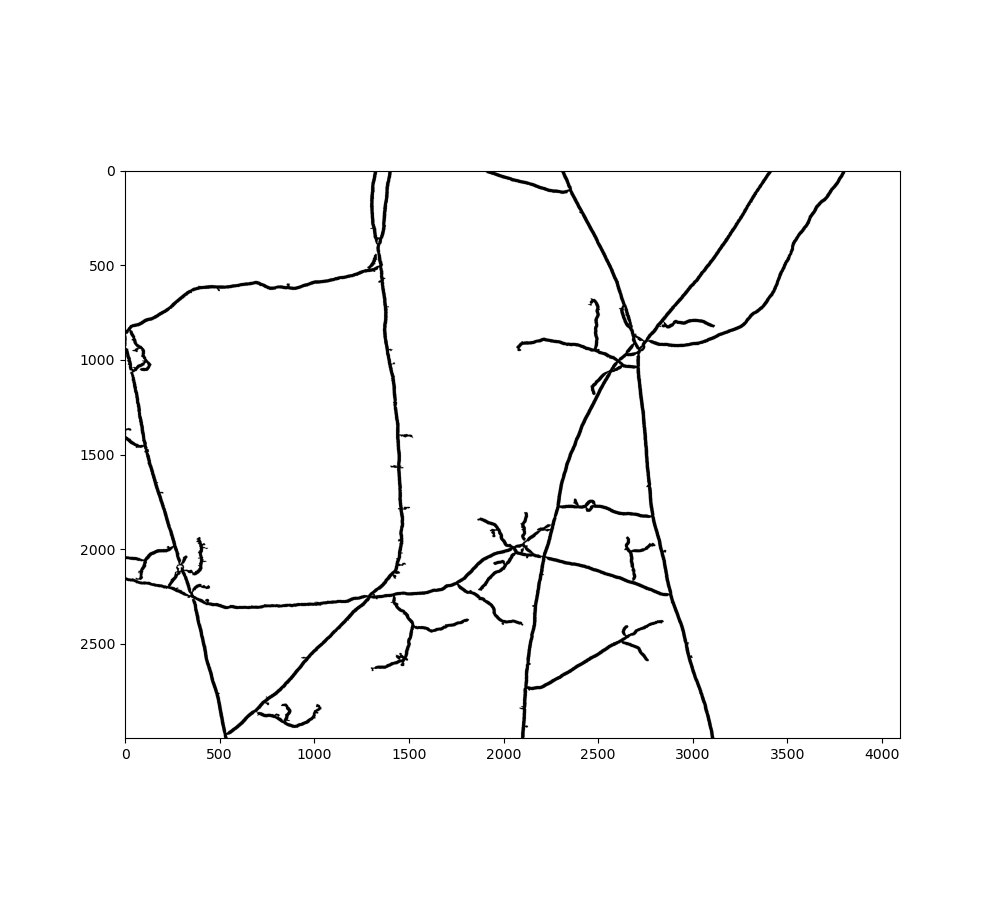

In [28]:
import cv2 as cv
from amftrack.pipeline.functions.node_id import remove_spurs
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
    generate_skeleton,
)

no = 15
si = [20]
low = 30
high = 100
from amftrack.pipeline.functions.extract_skel import bowler_hat

for index, im in enumerate(ims):
    boundaries = int(tileconfig[2][index][0] - np.min(xs)), int(
        tileconfig[2][index][1] - np.min(ys)
    )
    if (
        boundaries[1] <= linex < boundaries[1] + shape[0]
        and boundaries[0] <= liney < boundaries[0] + shape[1]
    ):
        print(index)
        im_cropped = im
        im_blurred = cv2.blur(im_cropped, (200, 200))
        im_back_rem = (
            (im_cropped)
            / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred)
            * 120
        )
        bowled_hat = bowler_hat(-im_back_rem, no, si)
        transformed = 255 * (bowled_hat)
        hyst = filters.apply_hysteresis_threshold(transformed, low, high)
        kernel = np.ones((3, 3), np.uint8)
        dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
        for i in range(3):
            dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
            dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilated = dilation > 0

        nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
            dilated.astype(np.uint8), connectivity=8
        )
        # connectedComponentswithStats yields every seperated component with information on each of them, such as size
        # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        # minimum size of particles we want to keep (number of pixels)
        # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
        min_size = 4000

        # your answer image
        img2 = np.zeros((dilated.shape))
        # for every component in the image, you keep it only if it's above min_size
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                img2[output == i + 1] = 1
        skeletonized = cv.ximgproc.thinning(np.array(255 * img2, dtype=np.uint8))
        nx_g = generate_nx_graph(
            from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized))
        )
        g, pos = nx_g
        nx_graph, pos = remove_spurs(g, pos)
        skel = generate_skeleton(nx_graph, dim=(3000, 4096)).todense()
        #         skeletonized = cv.ximgproc.thinning(np.array(255*img2,dtype=np.uint8))
        #         nx_g = generate_nx_graph(from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized)))
        #         g,pos= nx_g
        #         tips = [node for node in g.nodes if g.degree(node)==1]
        #         dilated_bis = np.copy(img2)
        #         for tip in tips:
        #             branch = np.array(orient(g.get_edge_data(*list(g.edges(tip))[0])['pixel_list'],pos[tip]))
        #             orientation = branch[0]-branch[min(branch.shape[0]-1,20)]
        #             orientation = orientation/(np.linalg.norm(orientation))
        #             window = 20
        #             x,y = pos[tip][0],pos[tip][1]
        #             if x-window>=0 and x+window< dilated.shape[0] and y-window>=0 and y+window< dilated.shape[1]:
        #                 shape_tip = dilated[x-window:x+window,y-window:y+window]
        #     #             dist = 20
        #                 for i in range(dist):
        #                     pixel = (pos[tip]+orientation*i).astype(int)
        #                     xp,yp = pixel[0],pixel[1]
        #                     if xp-window>=0 and xp+window< dilated.shape[0] and yp-window>=0 and yp+window< dilated.shape[1]:
        #                         dilated_bis[xp-window:xp+window,yp-window:yp+window]+=shape_tip
        #         dilation = cv.dilate(dilated_bis.astype(np.uint8) * 255,kernel,iterations = 1)
        #         for i in range(3):
        #             dilation=cv.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        #             dilation = cv.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        #         skeletonized = cv2.ximgproc.thinning(np.array(255*(dilation>0),dtype=np.uint8))
        print("Raw image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(-im, cmap="Greys")
        print("Raw image with background removed")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(-im_back_rem, cmap="Greys")
        print("bowled image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(bowled_hat, cmap="Greys")
        print("final transformed image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(transformed, cmap="Greys")
        print("threhsolded image")
        fig = plt.figure(figsize=(10, 9))
        ax = fig.add_subplot(111)
        ax.imshow(dilated > 0, cmap="Greys")
        print("threhsolded image")
        fig = plt.figure(figsize=(10, 9))

        ax = fig.add_subplot(111)
        ax.imshow(img2 > 0, cmap="Greys")
        #         print('extended tips')
        #         fig=plt.figure(figsize=(10,9))
        #         ax = fig.add_subplot(111)
        #         ax.imshow(dilated_bis>0,cmap = 'Greys')
        #         print('final_skel')
        # #         fig=plt.figure(figsize=(10,9))
        # #         ax = fig.add_subplot(111)
        # #         ax.imshow(cv2.normalize(abs(hessian), None, 0, 255, cv2.NORM_MINMAX)-255*dilated)
        plot_t_tp1([], [], None, None, skel, im_back_rem)

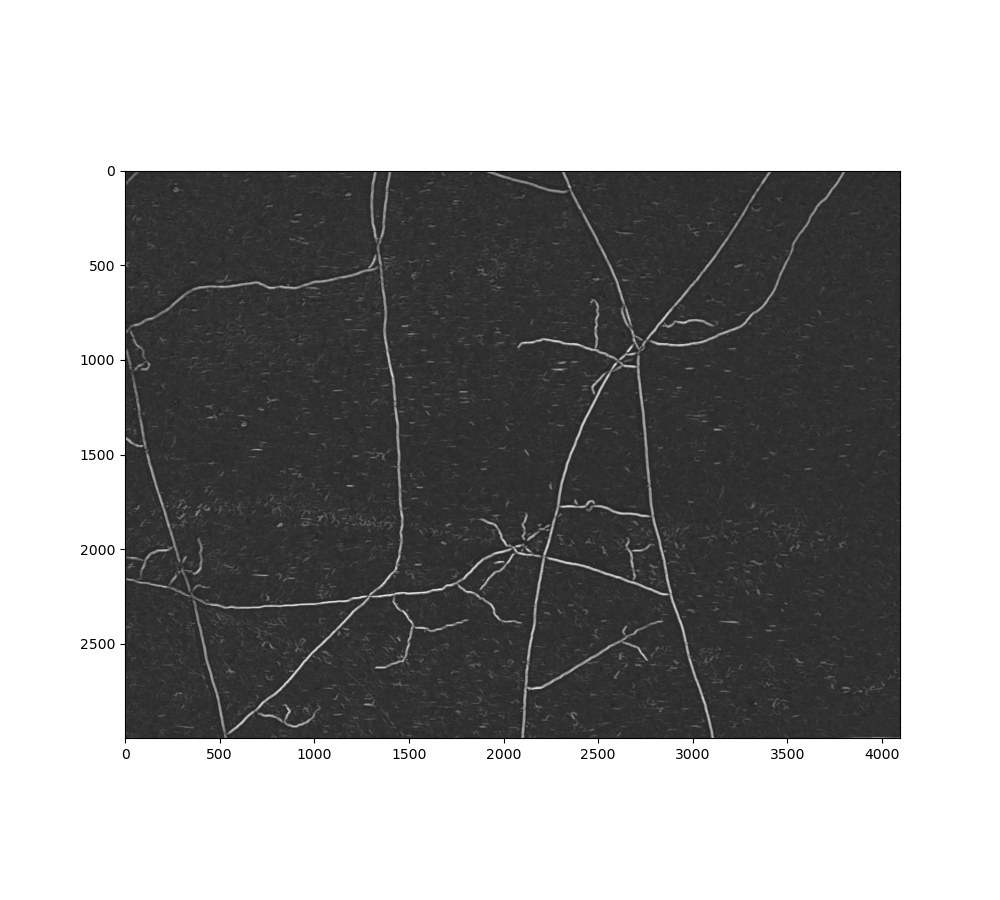

In [20]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.imshow(transformed, cmap="Greys")

In [13]:
folders2 = folders.loc[folders["Plate"].isin([88, 785, 792])]

In [14]:
folders2

folder Plate PrincePos    root strain    medium split  \
1755  20211009_1815_Plate38   785        38  Carrot     A5  001P100N     Y   
1756  20210922_2313_Plate17    88        17  Carrot     A5  001P100N     Y   
1761  20211004_0900_Plate17    88        17  Carrot     A5  001P100N     Y   
1763  20210918_1729_Plate21   792        21  Carrot     A5  001P100N     Y   
1764  20210930_2029_Plate38   785        38  Carrot     A5  001P100N     Y   
...                     ...   ...       ...     ...    ...       ...   ...   
2685  20210921_0516_Plate17    88        17  Carrot     A5  001P100N     Y   
2686  20210917_1318_Plate21   792        21  Carrot     A5  001P100N     Y   
2688  20210916_2307_Plate17    88        17  Carrot     A5  001P100N     Y   
2690  20211008_0616_Plate38   785        38  Carrot     A5  001P100N     Y   
2691  20210917_0118_Plate21   792        21  Carrot     A5  001P100N     Y   

     Temp CrossDate /Img/TileConfiguration.txt.registered  ...  \
1755  NaN  20210928                                  True  ...   
1756  NaN  20210915                                  True  ...   
1761  NaN  20210915                                  True  ...   
1763  NaN  20210915                                  True  ...   
1764  NaN  20210928                                  True  ...   
...   ...       ...                                   ...  ...   
2685  NaN  20210915                                  True  ...   
2686  NaN  20210915                                  True  ...   
2688  NaN  20210915                                  True  ...   
2690  NaN  20210928                                  True  ...   
2691  NaN  20210915                                  True  ...   

     /Analysis/skeleton_masked_compressed.mat  \
1755                                     True   
1756                                     True   
1761                                     True   
1763                                     True   
1764                                     True   
...                                       ...   
2685                                     True   
2686                                     True   
2688                                     True   
2690                                     True   
2691                                     True   

     /Analysis/skeleton_pruned_compressed.mat /Analysis/transform.mat  \
1755                                    False                   False   
1756                                    False                   False   
1761                                    False                   False   
1763                                    False                   False   
1764                                    False                   False   
...                                       ...                     ...   
2685                                    False                   False   
2686                                    False                   False   
2688                                    False                   False   
2690                                    False                   False   
2691                                    False                   False   

     /Analysis/transform_corrupt.mat  \
1755                           False   
1756                           False   
1761                           False   
1763                           False   
1764                           False   
...                              ...   
2685                           False   
2686                           False   
2688                           False   
2690                           False   
2691                           False   

     /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
1755                                       False                       False   
1756                                       False                       False   
1761                                       False                       False   
1763                    

***Mask baits and border of the petri dish***

In [6]:
num_parallel = 120
time = "10:00"
thresh = 40
args = [thresh, directory]
run_parallel(
    "mask_skel.py", args, folders, num_parallel, time, "mask", cpus=128, node="fat"
)

Submitted batch job 2390302


***Check Masking***

139


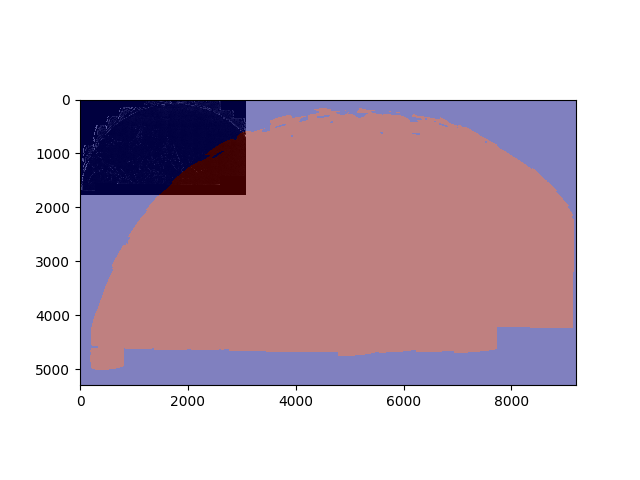

In [7]:
plates = list(set(list(folders["Plate"].values)))
plates = ["139"]
for plate in plates:
    print(plate)
    select = folders.loc[folders["Plate"] == plate]
    folder_list = list(select["folder"])
    folder_list.sort()
    skels = []
    ims = []
    masks = []
    kernel = np.ones((5, 5), np.uint8)
    itera = 1
    start = choice(range(len(folder_list)))
    finish = start + 2
    kernel = np.ones((5, 5), np.uint8)
    for folder in folder_list[start:finish]:
        path_snap = directory + folder
        skel_info = read_mat(path_snap + "/Analysis/skeleton_masked_compressed.mat")
        skel = skel_info["skeleton"]
        skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
        mask_info = read_mat(path_snap + "/Analysis/mask.mat")
        mask = mask_info["mask"]
        masks.append(mask)
        im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
        ims.append(im)
    start = 0
    finish = start + 1
    for i in range(start, finish):
        plot_t_tp1([], [], None, None, masks[i], ims[i])

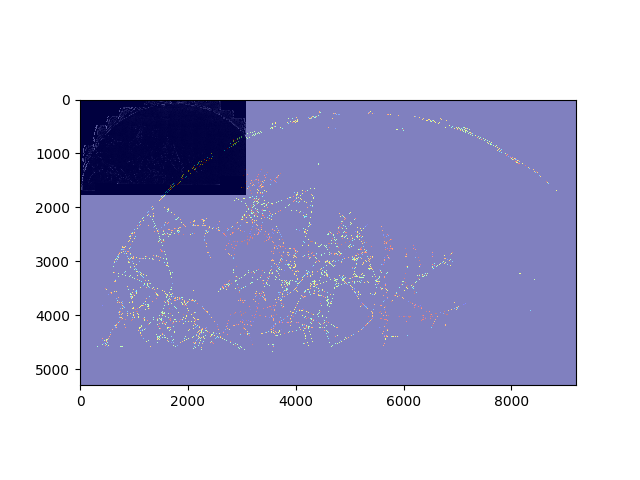

In [8]:
plt.close("all")
start = 0
finish = start + 1
for i in range(start, finish):
    plot_t_tp1([], [], None, None, skels[i], ims[i])

***Prune Graph***

In [9]:
num_parallel = 128
time = "6:00:00"
threshold = 0.1
args = [threshold, directory]
run_parallel(
    "prune_skel.py",
    args,
    folders,
    num_parallel,
    time,
    "prune_graph",
    cpus=128,
    node="fat",
)

Submitted batch job 2390332


In [7]:
from subprocess import call

for folder in folder_list[0:1]:
    path_snap = directory + folder
    print(path_snap)
    call(f"rm -r {path_snap}", shell=True)

/projects/0/einf914/data/20201208_1050_Plate22


***Check Pruned Graphs***

In [10]:
select = folders
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
masks = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
start = 0
finish = start + 2
kernel = np.ones((5, 5), np.uint8)
for folder in folder_list[start:finish]:
    path_snap = directory + folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned_compressed.mat")
    skel = skel_info["skeleton"]
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

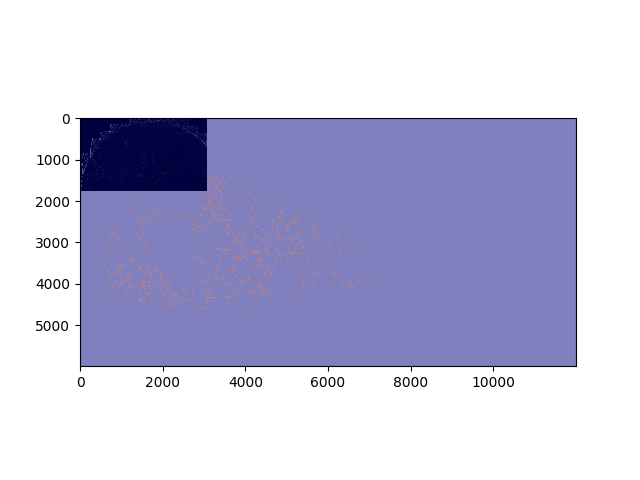

In [11]:
plot_t_tp1([], [], None, None, skels[0], ims[0])

In [12]:
skel = read_mat(path_snap + "/Analysis/skeleton_pruned.mat")["skeleton"]
skeleton = scipy.sparse.dok_matrix(skel)
nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))


path_save = path_snap + "/Analysis/nx_graph_pruned_labeled.p"
print(path_save)
pickle.dump((nx_graph, pos), open(path_save, "wb"))

/projects/0/einf914/data/20201217_0835_Plate09/Analysis/nx_graph_pruned_labeled.p


***Realign***

In [22]:
plates = list(set(list(folders["Plate"].values)))
for plate in plates:
    select = folders.loc[folders["Plate"] == plate]
    num_parallel = 128
    time = "12:00:00"
    thresh = 10000  # For R. irregularis, thresh 10000 is good. For Aggregatum, higher may be necessary
    args = [thresh, directory]
    run_parallel(
        "final_alignment.py",
        args,
        select,
        num_parallel,
        time,
        "realign",
        cpus=128,
        node="fat",
    )

Submitted batch job 1100879
Submitted batch job 1100880


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.
sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.


***Check Alignment***

In [44]:
plt.close("all")
select = folders
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
masks = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
start = 0
finish = start + 1
kernel = np.ones((5, 5), np.uint8)
for folder in folder_list[start:finish]:
    path_snap = directory + folder
    transform = sio.loadmat(path_snap + "/Analysis/transform.mat")
    print(transform)

# start = 0
# for j in range(start,start + 5):
#     print(dates[j],j+begin)
#     skeleton1,skeleton2 = skel_docs[j],skel_docs[j+1]
#     R,t = Rs[j],ts[j]
#     skelet_pos = np.array(list(skeleton1.keys()))
#     samples = np.random.choice(skelet_pos.shape[0],20000)
#     X = np.transpose(skelet_pos[samples,:])
#     skelet_pos = np.array(list(skeleton2.keys()))
#     samples = np.random.choice(skelet_pos.shape[0],20000)
#     Y = np.transpose(skelet_pos[samples,:])
#     fig=plt.figure(figsize=(10,9))
#     ax = fig.add_subplot(111)
#     Yrep=np.transpose(np.transpose(np.dot(R,X))+t)
#     ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
#     ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Feb 12 17:31:54 2022', '__version__': '1.0', '__globals__': [], 'R': array([[ 9.99999995e-01,  9.76786574e-05],
       [-9.76786574e-05,  9.99999995e-01]]), 't': array([[-21.09233967, -23.36649439]])}


In [43]:
transform

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Feb 12 17:31:54 2022',
 '__version__': '1.0',
 '__globals__': [],
 'R': array([[ 9.99999995e-01,  9.76786574e-05],
        [-9.76786574e-05,  9.99999995e-01]]),
 't': array([[-21.09233967, -23.36649439]])}

***Create realigned Skeleton***

In [8]:
plates = list(set(list(folders["Plate"].values)))
for plate in plates:
    select = folders.loc[folders["Plate"] == plate]
    num_parallel = 128
    time = "12:00:00"
    args = [directory]
    run_parallel(
        "realign.py",
        args,
        select,
        num_parallel,
        time,
        "create_realign",
        cpus=128,
        node="fat",
    )

sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.


Submitted batch job 1102816
Submitted batch job 1102817


sbatch: Single node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: You will be charged for 1.0 node. A full node consists of 128 CPU cores, 983040 MiB of memory and 0 GPUs and can be shared by up to 4 jobs.


***Check Fine Alignment***

In [18]:
start = 10
finish = start + 20
select = folders
folder_list = list(select["folder"])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5, 5), np.uint8)
itera = 1
for folder in folder_list[start:finish]:
    path_snap = directory + folder
    skel_info = read_mat(path_snap + "/Analysis/skeleton_realigned_compressed.mat")
    skel = skel_info["skeleton"]
    #     skels.append(skel)
    skels.append(cv2.dilate(skel.astype(np.uint8), kernel, iterations=itera))
    im = read_mat(path_snap + "/Analysis/raw_image.mat")["raw"]
    ims.append(im)

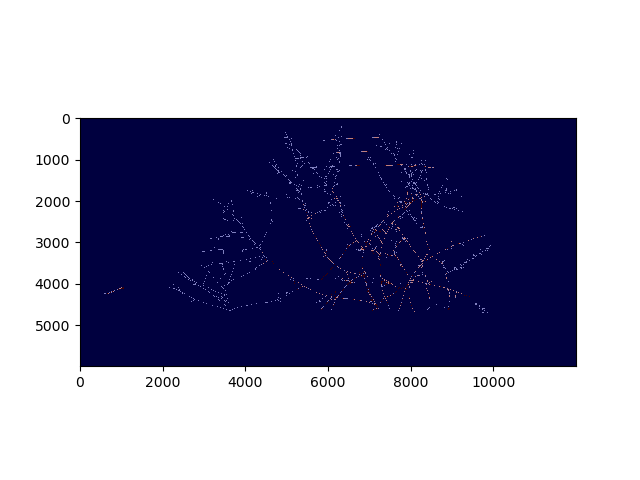

In [19]:
plt.close("all")
start = 0
finish = start + 1
for i in range(start, finish):
    plot_t_tp1([], [], None, None, skels[i], skels[i + 19])